По порядку.
1. Вначале моя задача сформулировать четко, что я хочу от себя при выполнении данного задания.
2. Потом понять, что мне максимально полезное может дать нотбук.
3. Теперь можно пошагово выполнять данные себе указания.

Нужно сделать:
1. нарисовать графики, где по порядку выстроены все значения пока каждому признаку, и посвечивается зелененьким или красным, здоровые или больные, таким образом любое скопление одногоо цвета - зацепка


2. можно построить гистограммы, где на оси Оx у нас пороговые значения, по Оу сколько пациентов больны: 
    1. процент больных, кто попал справа относительно всех больных, которые есть. пока минус.
    2. процент больных относительно всех пациентов, кто попал вправо


3. попробовать построить формулы!:) то есть найти линейную зависимость y = x0 + x1*P1 + x2*P2 + x3*P3 + x4*P4 + x5*P5    

In [52]:
%reload_ext autoreload

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from make_ready_data.make_ready_big_data import read_data, get_label, get_feat

from make_ready_data.make_ready_big_data import look_through_info, get_train_and_test_sets

from make_ready_data.make_ready_short_data import get_short_test_data_from_Roman

from make_ready_data.make_ready_short_data import get_short_test_data_from_Svetlana_G

from make_ready_data.create_features_indeces import get_labels_and_features_indeces

from make_ready_data.create_features_indeces import build_plot_for_best_features

from testing.testing_functions import testing_sick_patients, \
                    testing_sick_samples, extraxt_samples_from_new_test_data

In [53]:
info, final_filelist = read_data(dirpath="../")

data_sick, data_heal, inds_sick, inds_heal = look_through_info(info, final_filelist, dirpath="../")

plot_labels, indlist = get_labels_and_features_indeces()

In [54]:
_, _, _, _, patients_data = get_train_and_test_sets(data_sick, data_heal, 
                                                               inds_sick, inds_heal, 0, 
                                                               balanced_data=False,
                                                               make_shuffle=False)
# get mean vectors of 6 elements from group 1 and group 2
def extract_patients_mean_heal_and_sick(patients_data):
    patients_mean_heal = np.zeros((0, 6))
    patients_mean_sick = np.zeros((0, 6))
    for i,data in enumerate(patients_data):
        if data[0,-1] == 0:
            patients_mean_heal =np.concatenate((patients_mean_heal, data.mean(axis=0).reshape((1, -1))))
        else:
            patients_mean_sick =np.concatenate((patients_mean_sick, data.mean(axis=0).reshape((1, -1))))
    return patients_mean_heal, patients_mean_sick
patients_mean_heal, patients_mean_sick = extract_patients_mean_heal_and_sick(patients_data)

In [55]:
test_patients_data = get_short_test_data_from_Svetlana_G(dirpath='../data/test_data/')

test_patients_data.append(('Roman_patient', get_short_test_data_from_Roman("../data/short_test_data_from_Roman.csv")))


TQ_manualis dropped


In [56]:
# 92 samples from 18 very sick patients
def extract_data_very_sick(test_patients_data):
    data_very_sick = np.zeros((0, 5))
    for data in test_patients_data:
        data_very_sick =np.concatenate((data_very_sick, data[1]))
    ones = np.ones((data_very_sick.shape[0], 1))    
    data_very_sick = np.concatenate((data_very_sick, ones), axis=1)
    return data_very_sick
data_very_sick = extract_data_very_sick(test_patients_data)

In [36]:
# get mean vector of 5 elements from group 3
def extract_patients_mean_very_sick(test_patients_data):
    patients_mean_very_sick = np.zeros((len(test_patients_data), 5))
    for i,data in enumerate(test_patients_data):
        patients_mean_very_sick[i] = data[1].mean(axis=0)
    return patients_mean_very_sick
patients_mean_very_sick = extract_patients_mean_very_sick(test_patients_data)

In [5]:
# np.random.seed(42)
# np.random.shuffle(data_heal)
# np.random.shuffle(data_sick)
# np.random.shuffle(data_very_sick)

In [58]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

# vec - вектор с одним признаком 
# thresholds_space - просто множество всех точек, окрестность которых будем рассматривать
# STEP - промежуток между точками в thresholds_space
# WIN_SIZE - размер скользящего окна, которое применим к данным.
# Для каждого окна смотрим на все значения внутри, из них смотим сколько попало в текущих 
# промежуток в thresholds_space. Потом суммируем все окна в одно окно ( то есть в один вектор размера окна).
def merge_data_on_thresholds(vec, thresholds_space, STEP=STEP, WIN_SIZE=WIN_SIZE):
    n_slices = vec.size // WIN_SIZE # колво окон
    bins = np.zeros(thresholds_space.size)    
    eps = STEP/2+0.001
    for i in range(n_slices):
        v = vec[i*WIN_SIZE:(i+1)*WIN_SIZE]
        for i_thresh, thresh in enumerate(thresholds_space):
            bins[i_thresh] += ((v<thresh+eps) * (v>thresh-eps)).sum() # n_samples_for_cur_thresh_cur_win    
    return np.round(bins / n_slices)

def build_bar_for_one_group_one_feature(bin_heal, bin_sick, title, savefile_name, thresholds_space):
    width = 0.8*STEP/2
    plt.bar(thresholds_space+width/2, bin_heal, width=width, color='green', label='Heal')
    plt.bar(thresholds_space-width/2, bin_sick, width=width, color='red', label='Sick')
    plt.title(title)
    plt.xticks(thresholds_space)
    m1 = bin_heal.max() if bin_heal.size != 0 else 0 
    m2 = bin_sick.max() if bin_sick.size != 0 else 0 
    plt.yticks(np.arange(0, max(m1, m2)+2, 2))
    plt.xlabel('Feature\'s value', fontsize=15)
    plt.ylabel('Number of patients', fontsize=15)
    plt.savefig(savefile_name, bbox_inches='tight')
    plt.legend(fontsize=15)
    plt.show()
    
    
def short_axis_x(all_bins):
    edge1 = (all_bins!=0).argmax()
    edge2 = all_bins.size -(all_bins[::-1]!=0).argmax()
    return edge1, edge2

def build_bars_for_one_feature(data_heal, data_sick, data_very_sick, feat):

    vec_heal = data_heal[:, feat] # group 1
    vec_sick = data_sick[:, feat] # group 2
    vec_very_sick = data_very_sick[:, feat] # group 3
    
    vec = np.concatenate((vec_heal, vec_sick, vec_very_sick))
    start = np.round(vec.min(), 1)
    stop = np.round(vec.max(), 1)

    thresholds_space = np.arange(start, stop, STEP)
    bin_heal = merge_data_on_thresholds(vec_heal, thresholds_space, STEP, WIN_SIZE)
    bin_heal2 = merge_data_on_thresholds(vec_heal, thresholds_space, STEP, WIN_SIZE*2)
    bin_sick = merge_data_on_thresholds(vec_sick, thresholds_space, STEP, WIN_SIZE)
    bin_very_sick = merge_data_on_thresholds(vec_very_sick, thresholds_space, STEP, WIN_SIZE)

    e1, e2 = short_axis_x(bin_heal+bin_heal2+bin_sick+bin_very_sick)
    bin_heal = bin_heal[e1:e2]
    bin_heal2 = bin_heal2[e1:e2]
    bin_sick = bin_sick[e1:e2]
    bin_very_sick = bin_very_sick[e1:e2]    
    thresholds_space = thresholds_space[e1:e2]
    
    build_bar_for_one_group_one_feature(bin_heal, bin_sick, 
                                        title=plot_labels[feat]+ ", patients from group1 and group2", 
                                        savefile_name=plot_labels[feat]+ ", patients from group1 and group2", 
                                        thresholds_space=thresholds_space)

    build_bar_for_one_group_one_feature(bin_heal, bin_very_sick, 
                                        title=plot_labels[feat]+ ", patients from group1 and group3", 
                                        savefile_name=plot_labels[feat]+ ", patients from group1 and group3", 
                                        thresholds_space=thresholds_space)

    build_bar_for_one_group_one_feature(bin_heal2, bin_sick+bin_very_sick, 
                                        title=plot_labels[feat]+ ", patients from all three groups", 
                                        savefile_name=plot_labels[feat]+ ", patients from all three groups", 
                                        thresholds_space=thresholds_space)



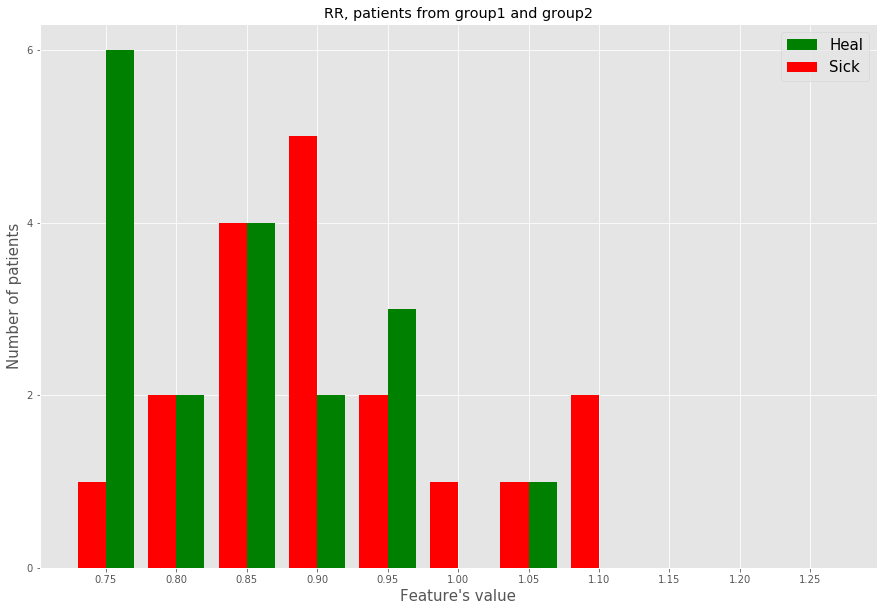

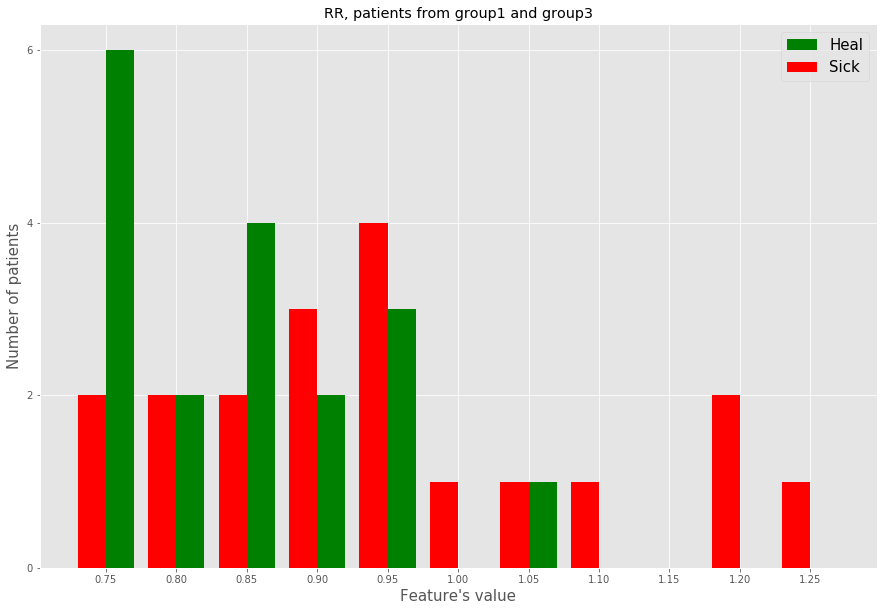

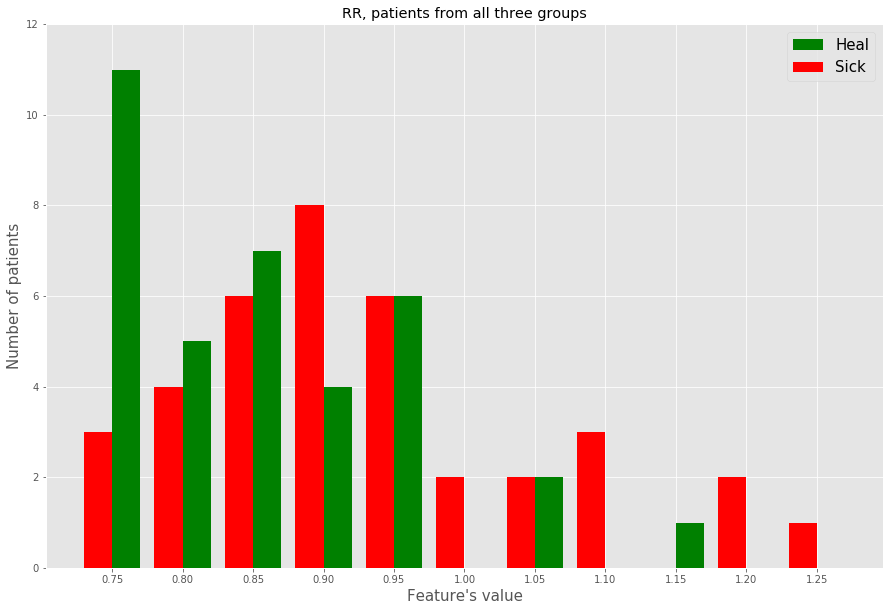

In [65]:
STEP=0.05; WIN_SIZE=18    
build_bars_for_one_feature(patients_mean_heal, patients_mean_sick, patients_mean_very_sick, 4)

In [67]:
print(patients_mean_heal.shape)
print(patients_mean_sick.shape)

(41, 6)
(70, 6)
